# Large Scale Kernel Ridge Regression

In [101]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/kernellib')
sys.path.insert(0, '/home/emmanuel/code/kernellib')

In [102]:
import numpy as np
from kernellib.largescale import RKSKernelRidge, KernelRidge as RKernelRidge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Sample Data

In [103]:
seed = 123
rng = np.random.RandomState(seed)
n_train, n_test = 10000, 1000
d_dimensions = 1
noise = 0.1

xtrain = rng.randn(n_train, d_dimensions)
ytrain = np.sin(xtrain) + noise * rng.randn(n_train, d_dimensions)

xtest = rng.randn(n_test, d_dimensions)
ytest = np.sin(xtest) + noise * rng.randn(n_test, d_dimensions)

# training
n_components = 10
alpha = 1e-3
gamma = 1.0

## Random Kitchen Sinks Regression

In this method, I implement the Random Kitchen Sinks algorithm found [here](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html) and [here](https://people.eecs.berkeley.edu/~brecht/kitchensinks.html). I don't try and transform the problem into a matrix approximation and then fit it into the KRR framework. This is largely because the RKS algorithm that they implement use complex values that need to be present in solving and transforming the data. If the complex values are taken out before the transformation, the results are garbage. Furthermore, some experiments that I ran (see below) show that the RKS as a transformer do not approximate the kernel matrix very well. So therefore, this algorithm comes as is. It's a shame that you cannot write the function as a transformer but the phenomenal results that you obtain make it worth it in my opinion.

In [104]:
rks_model = RKSKernelRidge(n_components=n_components, alpha=alpha, gamma=gamma, 
                           random_state=seed)
rks_model.fit(xtrain, ytrain)
y_pred = rks_model.predict(xtest)

In [112]:
%timeit rks_model.fit(xtrain, ytrain);
%timeit rks_model.predict(xtest);

9.67 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.82 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Root Mean Squared Error for RKS KRR: 0.100


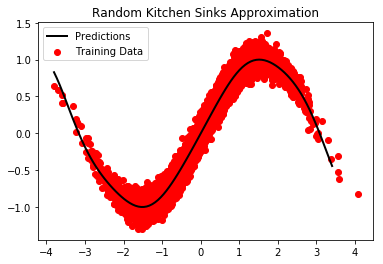

In [105]:
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for RKS KRR: {:.3f}'.format(rmse))

fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rks_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Kitchen Sinks Approximation')
plt.show()

#### Cross Validation Compatibility

In [106]:
param_grid = {
    'n_components': [1, 10, 50, 100, 200],
    'alpha': [1e0, 1e-1, 1e-2, 1e-3],
    'gamma': np.logspace(-2, 2, 5)
}
n_jobs = 24
cv = 3

rks_grid_model = GridSearchCV(RKSKernelRidge(random_state=seed),
                          param_grid=param_grid, n_jobs=n_jobs, cv=cv, 
                          verbose=1)
rks_grid_model.fit(xtrain, ytrain);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:  2.0min finished


In [107]:
y_pred = rks_grid_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for RKS KRR: {:.3f}'.format(rmse))

Root Mean Squared Error for RKS KRR: 0.100


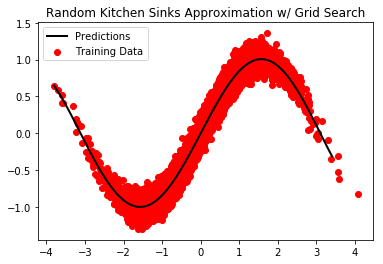

In [108]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rks_grid_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Kitchen Sinks Approximation w/ Grid Search')
plt.show()

## Nystrom Approximation

In [109]:
approximation = 'nystrom'
nys_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         gamma=gamma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation)
nys_model.fit(xtrain, ytrain);
y_pred = nys_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for Nystrom KRR: {:.4f}'.format(rmse))

Root Mean Squared Error for Nystrom KRR: 0.1020


In [110]:
%timeit nys_model.fit(xtrain, ytrain);
%timeit nys_model.predict(xtest);

9.21 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.49 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


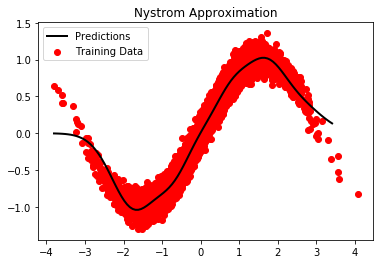

In [111]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = nys_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Nystrom Approximation')
plt.show()

### Nystrom w/ Grid Search

In [56]:
param_grid = {
    'kernel': ['rbf', 'poly'],
    'n_components': [1, 10, 50, 100, 200],
    'alpha': [1e0, 1e-1, 1e-2, 1e-3],
    'gamma': np.logspace(-2, 2, 5)
}
n_jobs = 24
cv = 3

nys_grid_model = GridSearchCV(RKernelRidge(random_state=seed,
                                       approximation=approximation),
                          param_grid=param_grid, n_jobs=n_jobs, cv=cv, 
                          verbose=1)
nys_grid_model.fit(xtrain, ytrain);

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=24)]: Done  12 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:  1.0min finished


In [58]:
y_pred = nys_grid_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for Nystrom KRR: {:.3f}'.format(rmse))
print('Best gamma:', nys_grid_model.best_estimator_.gamma)
print('Best alpha:',nys_grid_model.best_estimator_.alpha)
print('Best Number of features:', nys_grid_model.best_estimator_.n_components)
print('Best Kernel:', nys_grid_model.best_estimator_.kernel)

Root Mean Squared Error for Nystrom KRR: 0.100
Best gamma: 0.1
Best alpha: 0.1
Best Number of features: 100
Best Kernel: rbf


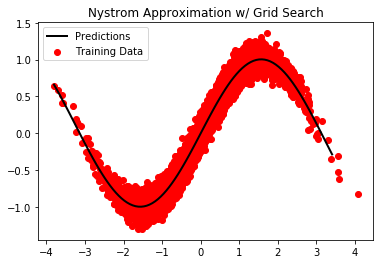

In [59]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = nys_grid_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Nystrom Approximation w/ Grid Search')
plt.show()

## Randomized Nystrom Matrix Approximation

In [85]:
approximation = 'rnystrom'
k_rank = 200
rnys_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         gamma=gamma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation,
                         k_rank=k_rank)
rnys_model.fit(xtrain, ytrain);
y_pred = rnys_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for Randomized Nystrom KRR: {:.4f}'.format(rmse))

Root Mean Squared Error for Randomized Nystrom KRR: 0.1010


In [91]:
%timeit rnys_model.fit(xtrain, ytrain);
%timeit rnys_model.predict(xtest);

9.11 ms ± 867 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.19 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


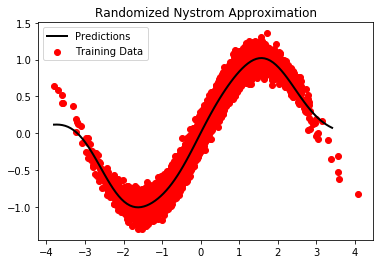

In [86]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rnys_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Randomized Nystrom Approximation')
plt.show()

## Random Fourier Features Matrix Approximation

In [95]:
approximation = 'rff'
rff_model = RKernelRidge(n_components=n_components,
                         alpha=alpha,
                         gamma=gamma,
                         kernel='rbf',
                         random_state=seed,
                         approximation=approximation)
rff_model.fit(xtrain, ytrain);
y_pred = rff_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for Random Fourier Features'
      'KRR: {:.4f}'.format(rmse))

Root Mean Squared Error for Random Fourier FeaturesKRR: 0.0999


In [97]:
%timeit rff_model.fit(xtrain, ytrain);
%timeit rff_model.predict(xtest);

9.39 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
832 µs ± 193 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


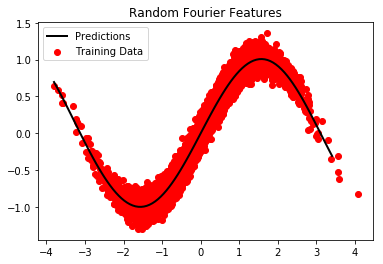

In [90]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rff_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Fourier Features')
plt.show()

### Gridsearch

In [92]:
param_grid = {
    'n_components': [1, 10, 50, 100, 200],
    'alpha': [1e0, 1e-1, 1e-2, 1e-3],
    'gamma': np.logspace(-2, 2, 5)
}
n_jobs = 24
cv = 3
approximation = 'rff'
rff_grid_model = GridSearchCV(RKernelRidge(random_state=seed,
                                       approximation=approximation),
                          param_grid=param_grid, n_jobs=n_jobs, cv=cv, 
                          verbose=1)
rff_grid_model.fit(xtrain, ytrain);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:   18.2s finished


In [94]:
y_pred = rff_grid_model.predict(xtest)
rmse = (1 / np.sqrt(n_test)) * np.linalg.norm(y_pred - ytest)
print('Root Mean Squared Error for Nystrom KRR: {:.3f}'.format(rmse))
print('Best gamma:', rff_grid_model.best_estimator_.gamma)
print('Best alpha:',rff_grid_model.best_estimator_.alpha)
print('Best Number of features:', rff_grid_model.best_estimator_.n_components)

Root Mean Squared Error for Nystrom KRR: 0.100
Best gamma: 1.0
Best alpha: 0.1
Best Number of features: 50


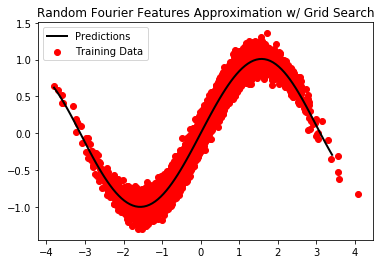

In [100]:
fig, ax = plt.subplots()

xplot = np.linspace(xtrain.min(), xtest.max(), 100)[:, np.newaxis]
yplot = rff_grid_model.predict(xplot)

ax.scatter(xtrain, ytrain, color='r', label='Training Data')
ax.plot(xplot, yplot, color='k', linewidth=2, label='Predictions')
ax.legend()
ax.set_title('Random Fourier Features Approximation w/ Grid Search')
plt.show()

### Timing Comparison

#### Number of Features

In [150]:
from sklearn.datasets import make_low_rank_matrix
import seaborn; seaborn.set()

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [157]:
m_range = (2 ** (np.arange(12.3, 20))).astype(int)
print(m_range.shape, m_range.min(), m_range.max())

(8,) 5042 645474


In [158]:
from sklearn.datasets import make_regression

In [159]:
print(t1.average, t1.stdev)

0.46411639344712186 0.002118701198427


In [160]:
%%time 
t_rks = list()
t_nys = list()
t_rnys = list()
t_rbf = list()
t_rff = list()

# training
n_components = 50
alpha = 1e-3
gamma = 1.0

for m in m_range:
    xtrain, ytrain = make_regression(n_samples=m, n_features=2000,
                                     n_informative=200, n_targets=1,
                                     effective_rank=50, noise=0.2, 
                                     random_state=seed)
    print(xtrain.shape)
    # -------------------------------
    # Random Kitchen Sinks)
    # -------------------------------
    rks_model = RKSKernelRidge(n_components=n_components, alpha=alpha, 
                               gamma=gamma, random_state=seed)
    t1 = %timeit -oq rks_model.fit(xtrain, ytrain)
    
    # ------------------------------
    # Nystrom
    # ------------------------------
    approximation = 'nystrom'
    nys_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t2 = %timeit -oq nys_model.fit(xtrain, ytrain);

    # ----------------------------
    # Randomized Nystrom
    # ----------------------------
    approximation = 'rnystrom'
    k_rank = n_components
    rnys_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation,
                             k_rank=k_rank)
    t3 = %timeit -oq rnys_model.fit(xtrain, ytrain);
    
    # -----------------------------------
    # RBF Sampler (Random Kitchen Sinks)
    # -----------------------------------
    approximation = 'rks'
    rks_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t4 = %timeit -oq rks_model.fit(xtrain, ytrain);   
    
    # -----------------------------
    # Random Fourier Features
    # -----------------------------
    approximation = 'rff'
    rff_model = RKernelRidge(n_components=n_components,
                             alpha=alpha,
                             gamma=gamma,
                             kernel='rbf',
                             random_state=seed,
                             approximation=approximation)
    t5 = %timeit -oq rff_model.fit(xtrain, ytrain);      
    
    t_rks.append(t1.best)
    t_nys.append(t2.best)
    t_rnys.append(t3.best)
    t_rbf.append(t4.best)
    t_rff.append(t5.best)
    

    
    

(5042, 2000)
(10085, 2000)
(20171, 2000)
(40342, 2000)
(80684, 2000)
(161368, 2000)
(322737, 2000)
(645474, 2000)
CPU times: user 2h 4min 38s, sys: 4h 15min 33s, total: 6h 20min 11s
Wall time: 34min 36s


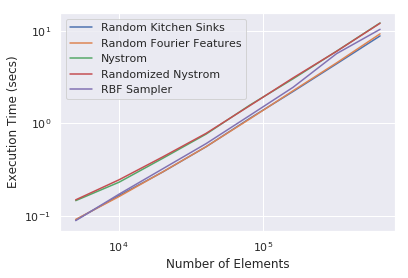

In [162]:


plt.loglog(m_range, t_rks, label='Random Kitchen Sinks')
plt.loglog(m_range, t_rff, label='Random Fourier Features')
plt.loglog(m_range, t_nys, label='Nystrom')
plt.loglog(m_range, t_rnys, label='Randomized Nystrom')
plt.loglog(m_range, t_rbf, label='RBF Sampler')
plt.legend(loc='upper left')
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (secs)');



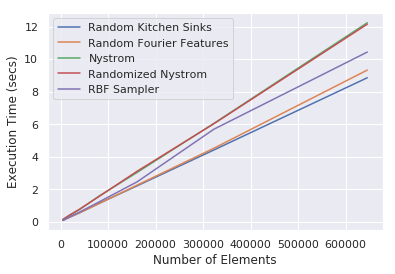

In [163]:
plt.plot(m_range, t_rks, label='Random Kitchen Sinks')
plt.plot(m_range, t_rff, label='Random Fourier Features')
plt.plot(m_range, t_nys, label='Nystrom')
plt.plot(m_range, t_rnys, label='Randomized Nystrom')
plt.plot(m_range, t_rbf, label='RBF Sampler')
plt.legend(loc='upper left')
plt.xlabel('Number of Elements')
plt.ylabel('Execution Time (secs)');
